In [1]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
import json
import networkx as nx
import matplotlib.pyplot as plt
import math

In [2]:
mp_face_mes = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
face_mesh = mp_face_mes.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [7]:
frame = cv2.imread('a.jpg') # read the image *** change the path to your image

In [8]:
H, W, _ = frame.shape
rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results_mesh = face_mesh.process(rgb_image)
mesh_points=np.array([np.multiply([p.x, p.y], [W, H]).astype(int) for p in results_mesh.multi_face_landmarks[0].landmark])
nose_tip = mesh_points[4]
forehead = mesh_points[151]
scale_factor = np.linalg.norm(forehead - nose_tip)
print(scale_factor)
if np.isclose(scale_factor, 0):
    scale_factor = 1e-6

187.32325002519042


In [9]:
graph = nx.Graph()
vertices = []
edges = []
distances = []

for edge in FACEMESH_TESSELATION:
    pointA_index = edge[0]
    pointB_index = edge[1]
    if [pointA_index, pointB_index] not in edges:
        edges.append([pointA_index, pointB_index])
        graph.add_edge(pointA_index, pointB_index)
        x_diff = results_mesh.multi_face_landmarks[0].landmark[pointA_index].x - results_mesh.multi_face_landmarks[0].landmark[pointB_index].x
        y_diff = results_mesh.multi_face_landmarks[0].landmark[pointA_index].y - results_mesh.multi_face_landmarks[0].landmark[pointB_index].y
        x_diff /= scale_factor
        y_diff /= scale_factor
        x_diff *= 100000
        y_diff *= 100000
        distances.append(math.sqrt(x_diff**2 + y_diff**2))
    if pointA_index not in vertices:
        vertices.append(pointA_index)
        graph.add_node(pointA_index)
    if pointB_index not in vertices:
        vertices.append(pointB_index)
        graph.add_node(pointB_index)

In [10]:
print("len vertices: ",len(vertices))
print("len edges: ",len(edges))
print("len distances: ",len(distances))

len vertices:  468
len edges:  2556
len distances:  2556


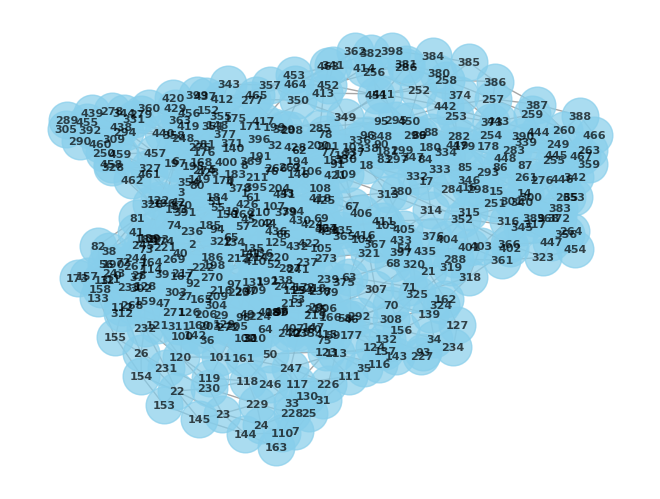

neighbors of 9:  [8, 336, 107, 337, 55, 151, 285, 108]


In [11]:
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=1, alpha=0.7)
plt.show()
print("neighbors of 9: ",list(graph.neighbors(9))) # print all neighbors of vertex 9

In [12]:
# transform the list of edges in a adjacency matrix
adjacency_matrix = np.zeros((len(vertices), len(vertices)))
for edge in edges:
    adjacency_matrix[edge[0]][edge[1]] = 1
    adjacency_matrix[edge[1]][edge[0]] = 1

print("Matriz de adjacência: ",adjacency_matrix)

Matriz de adjacência:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


In [13]:
# using the adjacency matrix find the neighbors of the vertex 9
neighbors = []
for i in range(len(adjacency_matrix)):
    if adjacency_matrix[9][i] == 1:
        # add the index of the neighbor
        neighbors.append(i)
print("Vizinhos de 9 pela matriz adjacência: ",neighbors)

Vizinhos de 9 pela matriz adjacência:  [8, 55, 107, 108, 151, 285, 336, 337]


In [15]:
# save the adjacency matrix in a file
np.savetxt('adjacency_matrix.csv', adjacency_matrix, delimiter=',')
# save the vertices in a file
np.savetxt('vertices.csv', vertices, delimiter=',')
# save the edges in a file
np.savetxt('edges.csv', edges, delimiter=',')
# save the distances in a file
np.savetxt('distances.csv', distances, delimiter=',')